The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
45.00 degrees
0.00 degrees


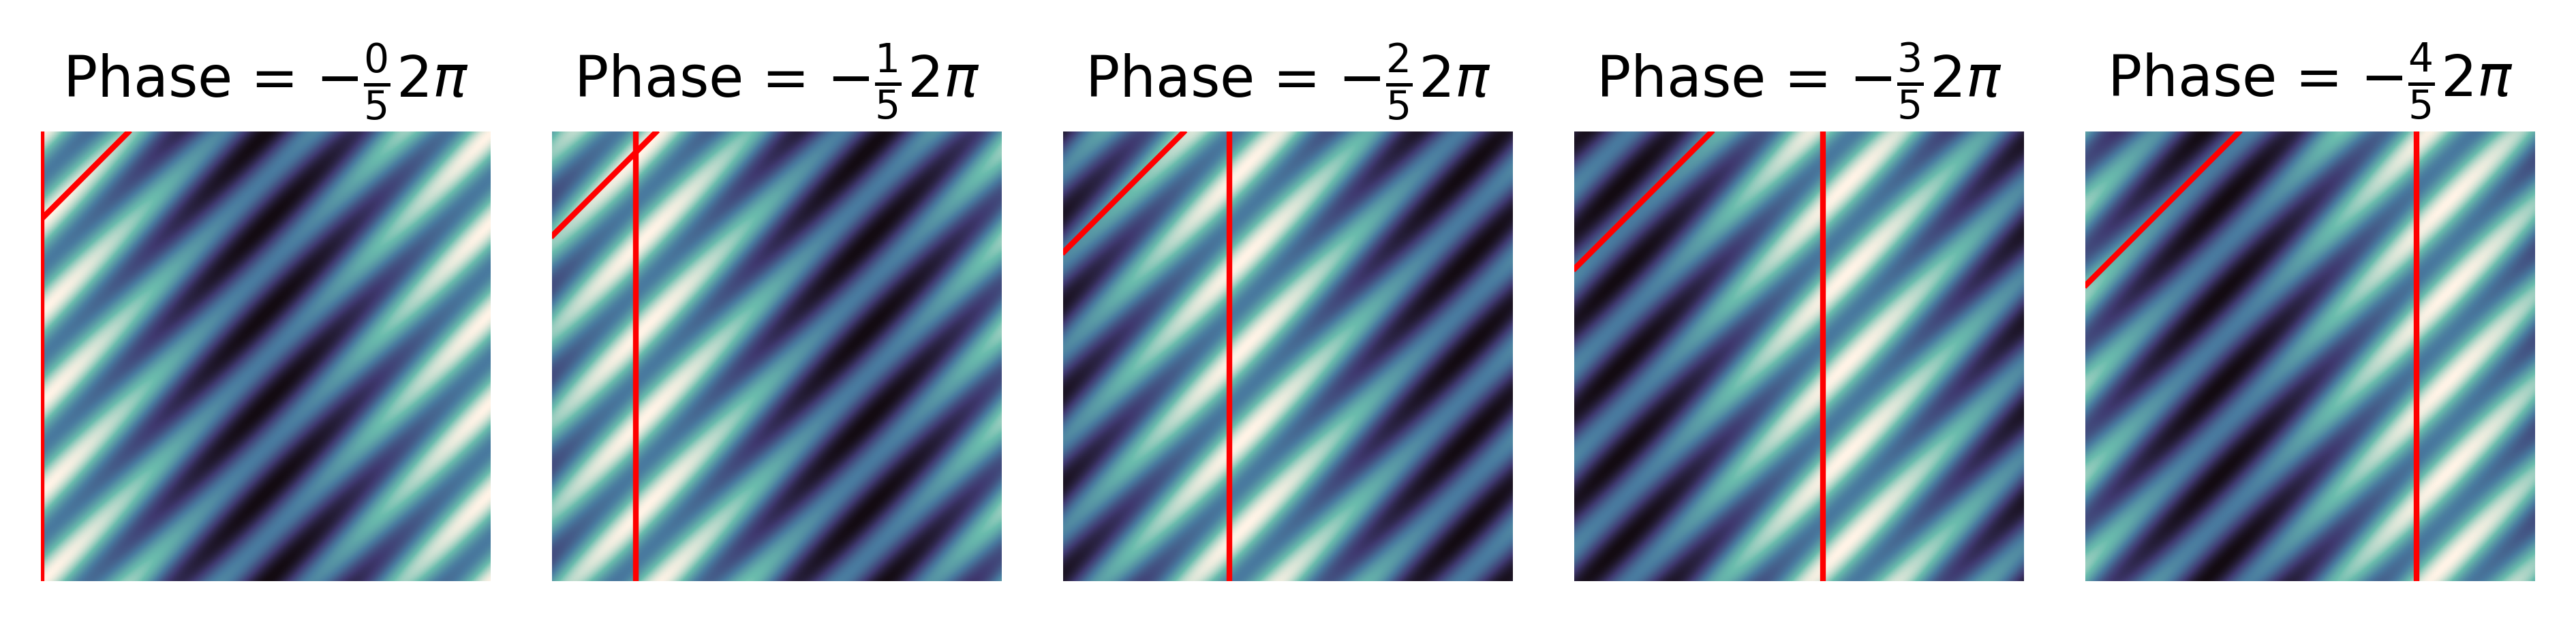

In [129]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 300

def normalize(image):
    image = image.real.to(torch.float32)
    image = (image - image.min()) / image.max()
    return image

colors = [(19/255, 11/255, 18/255), 
          (63/255, 57/255, 112/255),
          (73/255, 122/255, 159/255), 
          (106/255, 188/255, 173/255), 
          (1, 243/255, 230/255)]  # Define color transitions
cmap_name = 'fft'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

W = 244
H = 244
STEPS = 5
XPOS = 5
YPOS = 5

fig, ax = plt.subplots(1, STEPS)

images = [None] * 5

# fig.suptitle(f'Images generated by Inverse Fourier Transform with one active sinusoid of {np.arctan2(XPOS, YPOS) * (180 / np.pi):.2f} degrees', fontsize=14)
print(f'{np.arctan2(XPOS, YPOS) * (180 / np.pi):.2f} degrees')
print(f'{np.arctan2(0, 1) * (180 / np.pi):.2f} degrees')

for i, ax in enumerate(ax):

    magnitudes = torch.zeros(H, W)
    phases = torch.zeros(H, W)

    magnitudes[XPOS, YPOS] = 1
    magnitudes[0, 1] = 1
    phases[XPOS, YPOS] = -(i / STEPS) * 2 * torch.pi
    phases[0, 1] = -(i / STEPS) * 2 * torch.pi

    spectrum = torch.complex(torch.cos(phases) * magnitudes, torch.sin(phases) * magnitudes)

    # print(np.arctan2(5, 5) * (180 / np.pi))

    img = torch.fft.ifft2(magnitudes * torch.exp(1j * phases))
    images[i] = img


    ax.imshow(normalize(img).numpy(), cmap=cm)  
    ax.plot([0, 224/5 + 2 + ((224/5) * (i / STEPS))], [224/5 + 2 + ((224/5) * (i / STEPS)), 0],
            color='red', linewidth=1)
    ax.plot([224 * (i / STEPS), 224 * (i / STEPS)], [0, H-1], color='red', linewidth=1)

    ax.set_title(f'Phase = $-\\frac{{{i} }}{{{STEPS}}} 2 \\pi$', fontsize=10)  
    ax.axis('off')

plt.tight_layout()
plt.show()

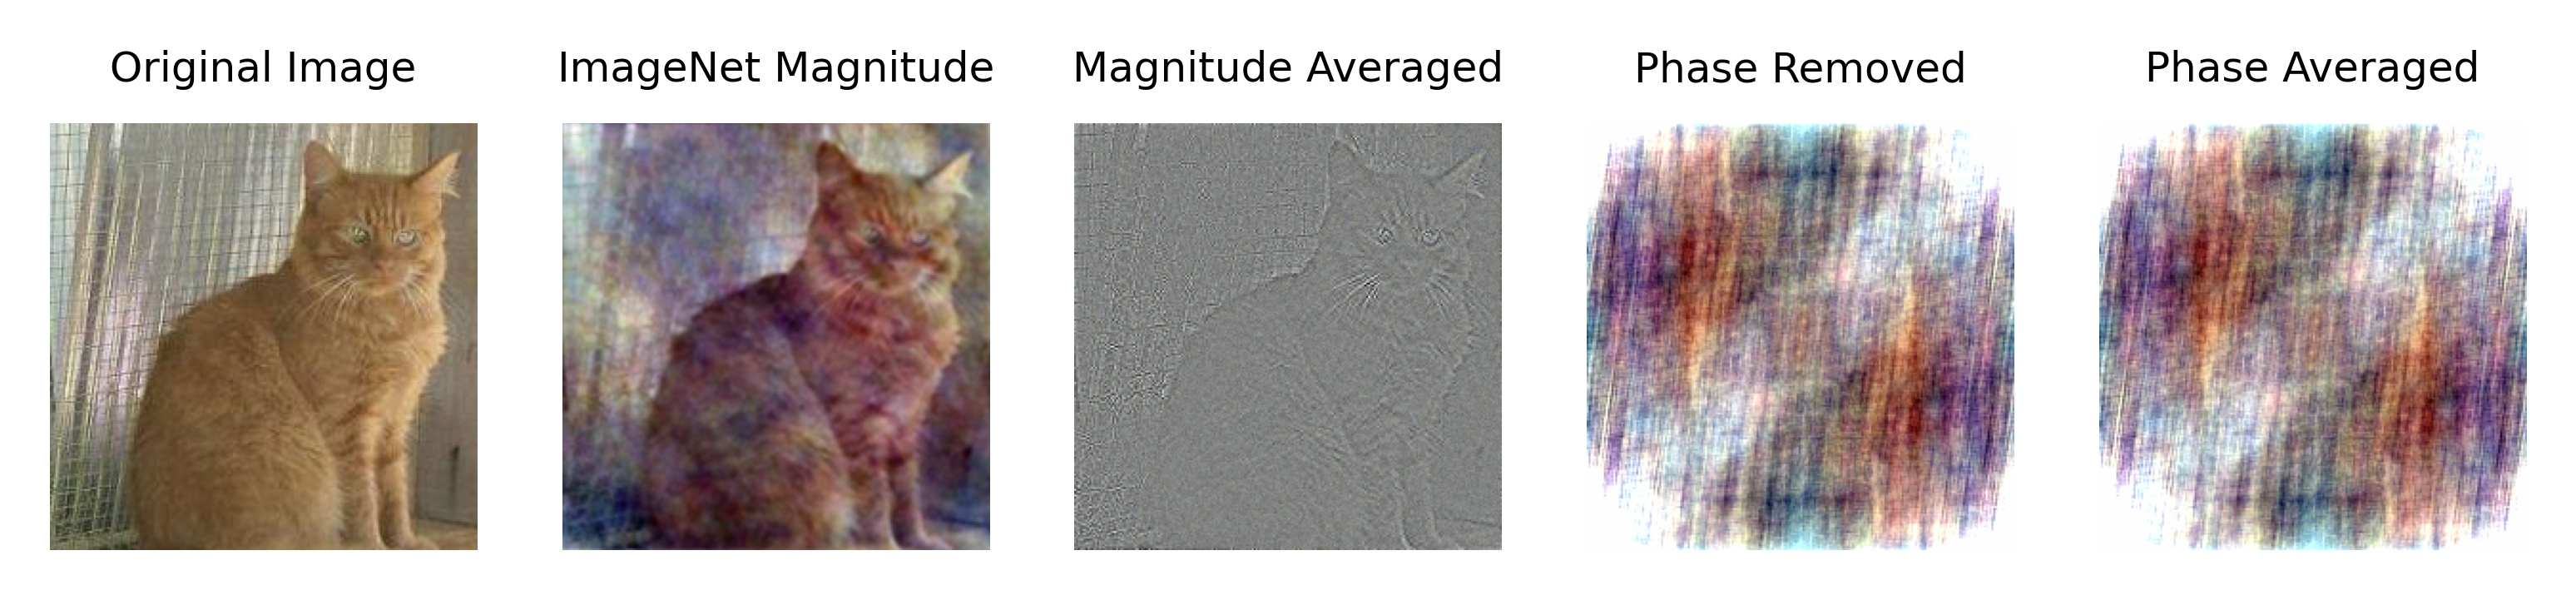

In [115]:
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from src.utils.imagenet import get_maco_magnitudes

def color_normalize(image):
    image = image.real.to(torch.float32)
    image -= torch.amin(image, dim=(1,2))[..., None, None]
    image /= torch.amax(image, dim=(1,2))[..., None, None] + 1e-4
    return image

def clip_quantile(image, quantile):
    return torch.clip(image, 
                      torch.quantile(image.flatten(start_dim=1), 0, dim=1)[..., None, None],
                      torch.quantile(image.flatten(start_dim=1), 1 - quantile, dim=1)[..., None, None])


cat_image = (pil_to_tensor(Image.open('../images/cat106.jpg')).to(torch.float32) / 255)

fig, ax = plt.subplots(1, 5)

ax[0].set_title('Original Image', fontsize=6)
ax[0].axis('off')
ax[0].imshow(np.moveaxis(cat_image.numpy(), 0, -1))

maco_magnitudes = get_maco_magnitudes((224, 113))
rfft_image = torch.fft.rfft2(cat_image)

magnitudes = torch.abs(rfft_image)
phases = torch.angle(rfft_image)

magnitudes_averaged = torch.fft.irfft2(torch.complex(
    torch.cos(phases) * maco_magnitudes, torch.sin(phases) * maco_magnitudes))
magnitudes_averaged = color_normalize(magnitudes_averaged)

# restored_image_p = torch.fft.irfft2(torch.complex(
#     torch.cos(phases + torch.pi) * magnitudes, torch.sin(phases + torch.pi) * magnitudes
# ))
# restored_image_p = color_normalize(restored_image_p)
# restored_image_m = torch.fft.irfft2(torch.complex(
#     torch.cos(phases - torch.pi) * magnitudes, torch.sin(phases - torch.pi) * magnitudes
# ))
# restored_image_m = color_normalize(restored_image_m)

ax[1].set_title('ImageNet Magnitude', fontsize=6)
ax[1].axis('off')
ax[1].imshow(np.moveaxis(magnitudes_averaged.numpy(), 0, -1))

magnitudes_averaged_same = torch.fft.irfft2(torch.complex(
    torch.cos(phases) * torch.mean(magnitudes, dim=(1,2))[..., None, None], 
    torch.sin(phases) * torch.mean(magnitudes, dim=(1,2))[..., None, None]))
magnitudes_averaged_same = color_normalize(magnitudes_averaged_same)

ax[2].set_title('Magnitude Averaged', fontsize=6)
ax[2].axis('off')
ax[2].imshow(np.moveaxis(magnitudes_averaged_same.numpy(), 0, -1))

phase_removed = torch.fft.irfft2(torch.complex(
    torch.cos(torch.zeros_like(phases)) * magnitudes,
    torch.sin(torch.zeros_like(phases)) * magnitudes))
phase_removed = color_normalize(clip_quantile(phase_removed, 0.1))

ax[3].set_title('Phase Removed', fontsize=6)
ax[3].axis('off')
ax[3].imshow(np.moveaxis(phase_removed.numpy(), 0, -1))

phase_averaged = torch.fft.irfft2(torch.complex(
    torch.cos(torch.mean(phases)) * magnitudes,
    torch.sin(torch.mean(phases)) * magnitudes))
phase_averaged = color_normalize(clip_quantile(phase_averaged, 0.1))

ax[4].set_title('Phase Averaged', fontsize=6)
ax[4].axis('off')
ax[4].imshow(np.moveaxis(phase_averaged.numpy(), 0, -1))

plt.show()

In [107]:
# test_img = torch.stack((torch.full((224, 244), fill_value=0.0), torch.full((224, 244), fill_value=0.0), torch.full((224, 244), fill_value=1.0)))
test_img = (pil_to_tensor(Image.open('../images/blue-image.jpg')).to(torch.float32) / 255)

test_img_fft = torch.fft.rfft2(test_img)

# plt.imshow(torch.abs(test_img_fft[2]), cmap='grey')
print(torch.mean(torch.abs(test_img_fft).flatten(start_dim=1), dim=1))
print(torch.abs(maco_magnitudes)[0].mean())

# plt.imshow(np.moveaxis(test_img.numpy(), 0, -1))
# plt.axis('off')
# plt.show()

tensor([32.9334, 32.8670, 33.0724])
tensor(111.5101)
